# <span style="color:#2834d4">매개변수 갱신</span>

최적화(optimization): 손실함수의 값을 가능한 낮추는 매개변수를 찾는 것, 즉 매개변수의 최적값을 찾는 문제를 푸는 것

## 1. 확률적 경사 하강법 (SGD)

### $\mathbf{W} \gets \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}$

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

사용방법 - 수도코드
```
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

## 2. 모멘텀 (Momentum)

### $\mathbf{v} \gets \alpha \mathbf{v} - \eta \frac{\partial L}{\partial \mathbf{W}}$
### $\mathbf{W} \gets \mathbf{W} + \mathbf{v}$

$\mathbf{v}$ : velocity

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

## 3. AdaGrad

learning rate decay (학습률 감소)
- 학습률을 점차 줄여가는 방법으로, 처음에는 크게 학습하다 조금씩 작게 학습하는 것.
- learning rate 값이 너무 작으면 학습시간이 길어지고, 너무 크면 발산하여 학습이 제대로 이루어지지 않음.

Adagrad : 개별 매개변수에 적응적으로 (adaptive) 학습률을 조정하면서 학습 진행
- 과거의 기울기를 제곱하여 계속 더해가면서 학습을 진행할수록 갱신 강도가 약해짐.

### $\mathbf{h} \gets \mathbf{h} + \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}}$
### $\mathbf{W} \gets \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}} \frac{\partial L}{\partial \mathbf{W}}$

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 4. RMSProp

과거의 모든 기울기를 균일하게 더해가는 것이 아니라, 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영하여 과거 기울기의 반영 규모를 기하급수적으로 감소시킴
- AdaGrad로 무한히 계속 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않는 문제를 개선한 기법

### $\mathbf{h} \gets \rho \mathbf{h} + (1-\rho) \frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}}$
### $\mathbf{W} \gets \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}} \frac{\partial L}{\partial \mathbf{W}}$

In [4]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 5. Adam

momentum + RMSProp

### $\mathbf{m} \gets \beta_1 \mathbf{m} + (1-\beta_1)\frac{\partial L}{\partial \mathbf{W}}$
### $\mathbf{v} \gets \beta_2 \mathbf{v} + (1-\beta_2)\frac{\partial L}{\partial \mathbf{W}} \odot \frac{\partial L}{\partial \mathbf{W}}$
### $\hat{\mathbf{m}} \gets \frac{m}{(1-\beta_1^t)}, \hat{\mathbf{v}} \gets \frac{v}{(1-\beta_2^t)}$
### $\mathbf{W} \gets \mathbf{W} - \eta \frac{\hat{\mathbf{m}}}{\sqrt{\hat{\mathbf{v}}}}$

In [5]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.t += 1
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]  # 일차 모멘텀
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)  # 이차 모멘텀
            m_unbias = self.m[key] / (1.0 - self.beta1**self.t)  # bias correction
            v_unbias = self.v[key] / (1.0 - self.beta2**self.t)  # bias correcion
            params[key] -= self.lr *  m_unbias / (np.sqrt(v_unbias) + 1e-7)

## 6. 갱신 방법 비교

<img src="img/compare_optimizer1.png">

**MNIST 데이터셋으로 본 갱신 방법 비교**

<img src="img/compare_optimizer2.png" align='left' width="30%" height="30%">

|iteration|SGD|Momentum|AdaGrad|Adam|
|:---:|:---:|:---:|:---:|:---:|
|0|2.311864598015662|2.385649391761|2.1177254991191226|2.1398345892056962|
|400|0.397280701092698|0.12505988816582034|0.0494271112834781|0.0792357420915904|
|900|0.22393582337790538|0.11924298272985065|0.02922040503059991|0.07950928723895823|
|1400|0.1469758364578464|0.0855866555229981|0.03847798248486493|0.04701864922897751|
|1900|0.25185541115620247|0.034430270259498776|0.016049158619572533|0.01428691276185064|

# <span style="color:#2834d4">가중치의 초깃값</span>

가중치 감소(weight decay): 가중치 매개변수의 값이 작아지도록 학습하는 방법
- 가중치 값을 작게하여 overfitting 방지

## 1. 초깃값을 0으로 하면? (= 균일한 값으로 설정하면?)

- 동일한 layer의 모든 뉴런에 같은 값이 입력되고 역전파에서도 가중치가 모두 똑같이 갱신되기 때문에, 가중치를 여러 개 갖는 의미를 사라지게 함

## 2. 은닉층의 활성화값 분포 - sigmoid 사용했을 때

- 활성화값: 활성화 함수의 출력 데이터

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def activation_value_dist(func, n):
    x = np.random.randn(1000, 100)  # 1000개의 데이터
    node_num = 100  # 각 은닉층의 노드(뉴런) 수
    hidden_layer_size = 5  # 은닉층이 5개
    activations = {}  # 이곳에 활성화 결과(활성화값)를 저장
   
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]
        w = np.random.randn(node_num, node_num) * n
        a = np.dot(x, w)
        z = func(a)
        activations[i] = z
        
    plt.figure(figsize=(15,4))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1)+"-layer")
        plt.hist(a.flatten(), 30, range=(0,1)) 
    plt.show()

In [7]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

### 표준편차를 1로 설정
- 기울기 소실 (gradient vanishing) 발생
    - 시그모이드 함수의 경우 출력이 0또는 1에 가까워지면 그 미분은 0에 다가가서 역전파의 기울기 값이 점점 작아지다 사라짐

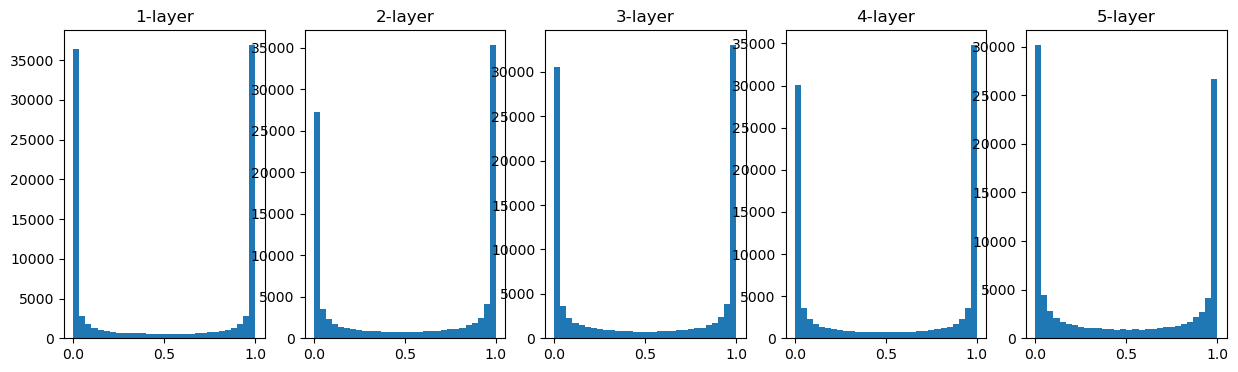

In [8]:
activation_value_dist(sigmoid, 1)

### 표준편차를 0.01로 설정
- 활성화값이 0.5부근에 집중되어 기울기 소실 문제가 발생하지 않음
- 그러나 활성화값들이 치우치면 표현력을 제한한다는 관점에서 문제가 됨
    - 다수의 뉴런이 거의 같은 값을 출력하고 있어 뉴런을 여러 개 둔 의미가 없어짐

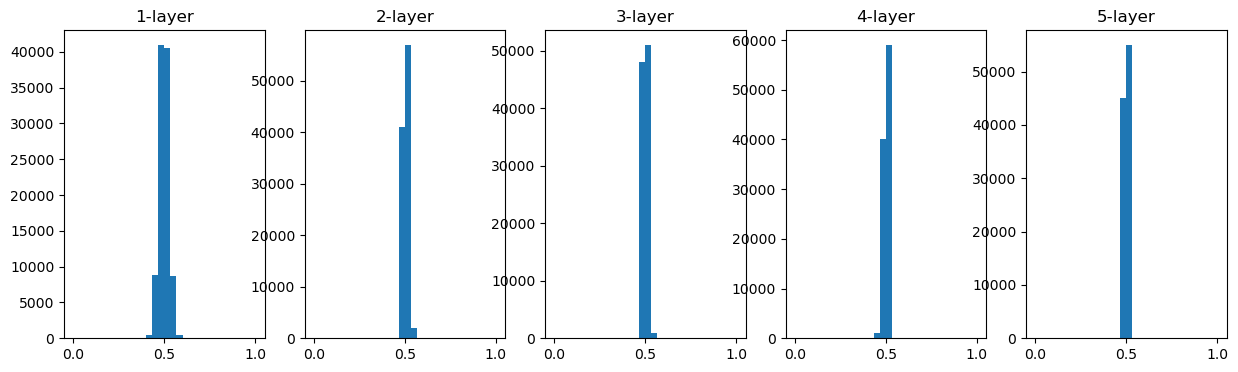

In [9]:
activation_value_dist(sigmoid, 0.01)

### Xavier initalization
- 앞 계층의 노드가 n개라면, 표준편차가 $\frac{1}{\sqrt{n}}$인 분포를 사용
- 층이 깊어질 수록 형태가 다소 일그러지지만 앞에서 본 방식보다 넓게 분포됨을 알 수 있음

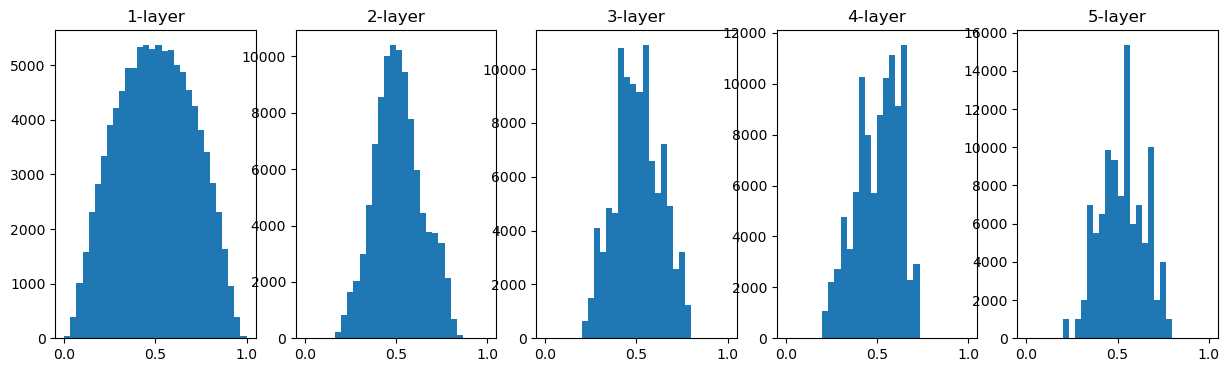

In [10]:
node_num = 100
activation_value_dist(sigmoid, np.sqrt(1.0 / node_num))

## 3. ReLU를 사용할 때의 가중치 초기값

In [11]:
def ReLU(x):
    return np.maximum(0, x)

### 표준편차를 0.01로 설정
- 각 층의 활성화값들은 아주 작은 값들이고 이는 역전파때 가중치의 기울기 역시 작아진다는 뜻
- 실제로도 학습이 거의 이루어지지 않을 것

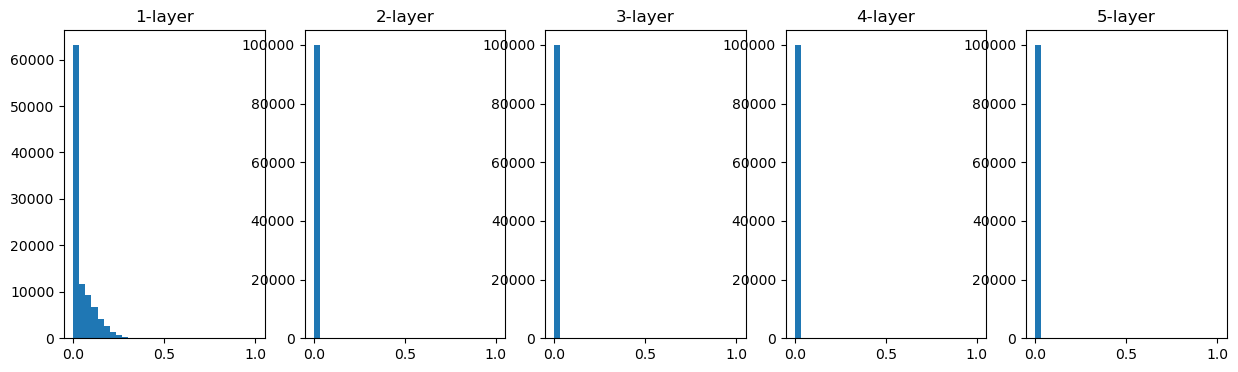

In [12]:
activation_value_dist(ReLU, 0.01)

### Xavier initalization
- 층이 깊어지면서 치우침이 조금씩 커짐
- 실제로 층이 깊어지면 활성화값들의 치우침도 커지고 학습할 때 기울기 소실 문제를 일으킴

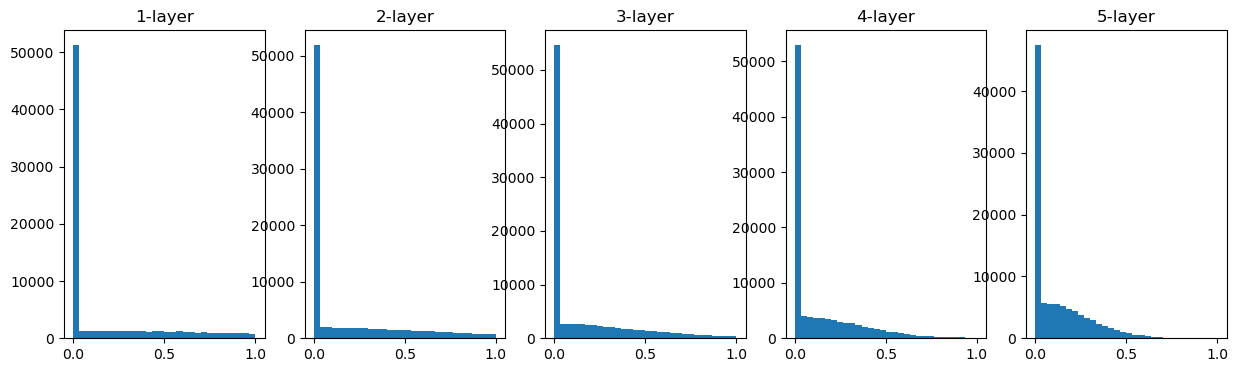

In [13]:
node_num = 100
activation_value_dist(ReLU, np.sqrt(1.0 / node_num))

### He initialization
- 앞 계층의 노드가 n개라면, 표준편차가 $\frac{2}{\sqrt{n}}$인 분포를 사용
    - ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 직감적으로 해석할 수 있음
- 모든 층에서 균일하게 분포되기 때문에 역전파때도 적절한 값이 나올 것으로 기대할 수 있음

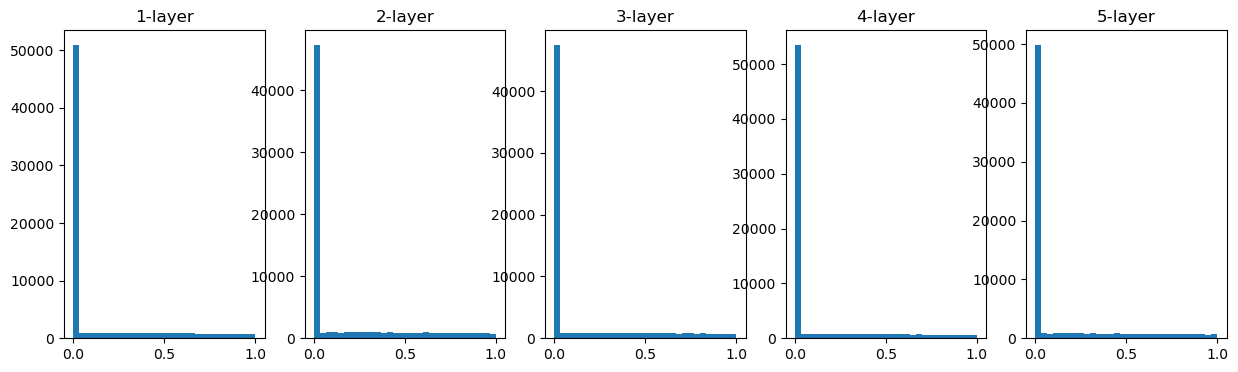

In [14]:
node_num = 100
activation_value_dist(ReLU, np.sqrt(2.0 / node_num))

## 4. MNIST 데이터셋으로 본 가중치 초깃값 비교

- 층별 뉴런 수가 100개인 5층 신경망에서 ReLU 사용

<img src="img/weight_init_compare.png" align='left' width="40%" height="40%">

|iteration|std=0.01|Xavier|He|
|:---:|:---:|:---:|:---:|
|0|2.302544725029941|2.3085964538202006|2.3380467942566465|
|400|2.303284375915534|1.4752362788755917|0.40676313851907686|
|900|2.3024281441488865|0.42736497442224114|0.2458057090695743|
|1400|2.302129356976167|0.4022931155339009|0.34895854989631847|
|1900|2.2979235879617343|0.3450216887304113|0.22400708029691246|

# <span style="color:#2834d4">배치 정규화(Batch Normalization)</span>

## 1. 배치 정규화 알고리즘

<img src="img/batch_normalization.png">

배치 정규화: 각 층에서의 활성화값이 적당히 분포되도록 조정하는 것으로, 활성화 함수 앞에 적용함
- 학습시 미니배치 단위로 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화함
- 정규화된 데이터에 고유한 scale(𝛾), shift(𝛽) 변환 수행.
    - 처음에는 𝛾=1, 𝛽=0 부터 시작하고 학습하면서 적합한 값으로 조정

### $$\mu_B \gets \frac{1}{m} \sum_m^{i=1}x_i, \qquad \sigma_B^2 \gets \frac{1}{m} \sum_m^{i=1}(x_i-\mu_B)^2, \qquad \hat{x}_i \gets \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \varepsilon}} \qquad y_i \gets \gamma \hat{x}_i + \beta$$

배치 정규화가 주목받는 이유
- 학습을 빨리 진행할 수 있음 (학습 속도 개선)
- 초깃값에 크게 의존하지 않음
- 오버피팅 억제 (드롭아웃 등의 필요성 감소)
    


## 2. 배치 정규화의 효과

<img src="img/bn_test.png">

# <span style="color:#2834d4">바른 학습을 위해</span>

## 1. 오버피팅(overfitting)

오버피팅: 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태
- 오버피팅이 주로 일어나는 경우
    - 매개변수가 많고 표현력이 높은 모델
    - 훈련 데이터가 적음

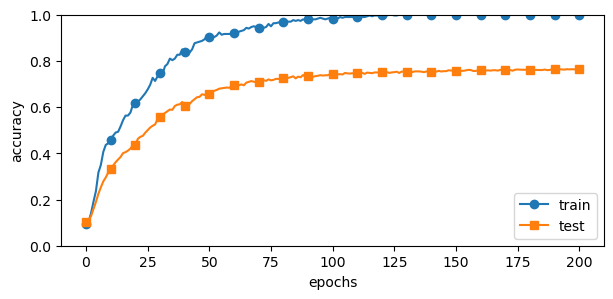

In [15]:
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_acc_list = []
test_acc_list = []
train_loss_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

plt.figure(figsize=(7, 3))
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 2. 가중치 감소 (weight decay)

가중치 감소: 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법
- 모든 가중치 각각의 손실함수에 정규화항인 $\frac{1}{2}\lambda W^2$을 더함
    - 𝜆: 정규화 세기를 조절하는 하이퍼파라미터로, 값이 커질수록 규제가 강해져 underfiiting 가능성이 높고, 값이 작아질수록 규제가 약해져 overfitting 가능성이 높음
- 가중치의 기울기를 구하는 계산에서는 그동안의 오차역전파법에 따른 결과에 정규화 항을 미분한 $\lambda W$를 더함


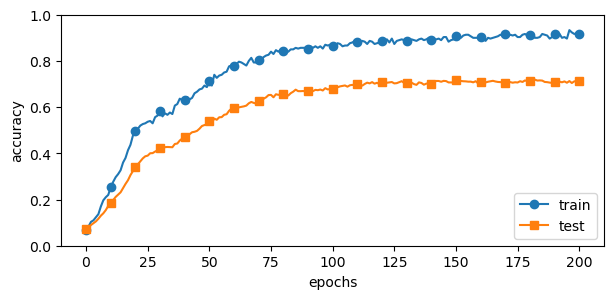

In [17]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay 설정 
weight_decay_lambda = 0.1
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

plt.figure(figsize=(7, 3))
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 3. 드롭아웃 (dropout)

드롭아웃: 뉴런을 임의로 삭제하면서 학습하는 방법으로, 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제
- train) 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택
- test) 모든 뉴런에 신호 전달. 단, 각 뉴런의 출력에 train 때 삭제 안 한 비율을 곱하여 출력

<img src="img/dropout.png" width="50%" height="50%">

In [18]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.randn(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

<img src="img/dropout_test.png" width="50%" height="50%" align='left'>

# <span style="color:#2834d4">적절한 하이퍼파라미터 값 찾기</span>

## 1. 검증 데이터 (validation data)

- 훈련 데이터: 매개변수 학습
- 검증 데이터: 하이퍼파라미터 성능 평가
    - 하이퍼파라미터의 성능을 평가할 때는 시험 데이터를 사용하면 안됨
    - 시험 데이터를 사용하여 하이퍼파라미터 조정하면 하이퍼파라미터 값이 시험 데이터에 오버피팅 되어 범용 성능이 떨어질 수 있음
- 시험 데이터: 신경망의 범용 성능 평가

## 2. 하이퍼파라미터 최적화

신경망의 하이퍼파라미터 최적화에서는 grid search 같은 규칙적 탐색보다 무작위로 샘플링해 탐색하는 편이 좋은 결과를 낸다고 알려져 있는데, 이는 최종 정확도에 미치는 영향력이 하이퍼파라미터마다 다르기 때문

1. 하이퍼파라미터 값의 범위 설정 - 0.001에서 1000 사이 ($10^{-3}$ ~ $10^3$)과 같이 10의 거듭제곱 단위로 범위를 지정 (로그 스케일로 지정)
2. 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출
3. 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도 평가 (단, 에폭은 작게 설정)
4. 2와 3을 특정횟수 반복하며 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힘

## 3. 하이퍼파라미터 최적화 구현하기

하이퍼파라미터 무작위 추출<br>
ex) 가중치 감소 계수를 $10^{-8}$ ~ $10^{-4}$, 학습률을 $10^{-6}$ ~ $10^{-2}$ 범위부터 시작

val acc:0.11 | lr:1.0885677327377536e-05, weight decay:8.894365068383043e-06
val acc:0.15 | lr:9.716167635311816e-06, weight decay:1.7454108666744364e-07
val acc:0.13 | lr:1.7082625741197613e-05, weight decay:2.728514965702526e-07
val acc:0.53 | lr:0.0038098902439379543, weight decay:1.8011405690488207e-08
val acc:0.19 | lr:8.620048948107615e-05, weight decay:2.161233894767683e-08
val acc:0.11 | lr:1.7588208001821254e-05, weight decay:1.3726080128938528e-07
val acc:0.21 | lr:0.00016496275776056027, weight decay:3.479867348044775e-05
val acc:0.76 | lr:0.007070959598375459, weight decay:5.975087228367633e-07
val acc:0.16 | lr:7.416776515719739e-05, weight decay:6.210429432455929e-07
val acc:0.14 | lr:3.0690290854304406e-05, weight decay:1.317481812816872e-05
val acc:0.08 | lr:1.3211287710912335e-06, weight decay:3.052708971503375e-05
val acc:0.43 | lr:0.0038038146252859094, weight decay:1.7254346998059582e-06
val acc:0.3 | lr:0.0015453609784912012, weight decay:4.0230148624589556e-07
val

Best-11(val acc:0.72) | lr:0.00699306081441603, weight decay:6.886188584440441e-07
Best-12(val acc:0.62) | lr:0.005481973186282814, weight decay:1.2559697049448419e-06
Best-13(val acc:0.61) | lr:0.0035564591155625687, weight decay:1.2714260728497557e-07
Best-14(val acc:0.6) | lr:0.0036226428123951044, weight decay:2.8381483529048152e-05
Best-15(val acc:0.53) | lr:0.0038098902439379543, weight decay:1.8011405690488207e-08
Best-16(val acc:0.51) | lr:0.003053478218851446, weight decay:2.3616932918847347e-05
Best-17(val acc:0.45) | lr:0.005861571368559597, weight decay:4.549950188222071e-05
Best-18(val acc:0.43) | lr:0.0038038146252859094, weight decay:1.7254346998059582e-06
Best-19(val acc:0.34) | lr:0.0012206264125195583, weight decay:1.4445992597855248e-05
Best-20(val acc:0.33) | lr:0.0010561988686978115, weight decay:9.180160155628719e-08


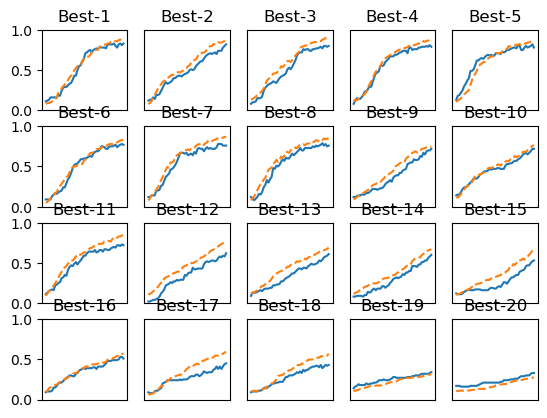

In [19]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:500]
t_train = t_train[:500]

validation_rate = 0.20  # 20%를 검증 데이터로 분할
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val, epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list

optimization_trial = 100
results_val = {}
results_train = {}

# 하이퍼파라미터 무작위 탐색
for _ in range(optimization_trial):
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    
    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

# <span style="color:#2834d4">정리</span>

- 매개변수 갱신 방법에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있음.
- 가중치 초깃값을 정하는 방법은 올바른 학습을 하는데 매우 중요하고, 'Xavier 초깃값'과 'He 초깃값'이 효과적.
- 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있고, 초깃값에 영향을 덜 받게 됨.
- 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있음.
- 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적임.